# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Targeted (Entity) Sentiment Identification


Shijia Huang

-----

In [1]:
!pip install -r requirements.txt

In [2]:
# Import basic libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import eli5
import pickle

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-22 01:24:16.309725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 01:24:17.672292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-05-22 01:24:17.672548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_

3.5.2


In [5]:
# Import sklearn libraries
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [6]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 16


## Read Data

In [7]:
%%time

# read in the article‘s sentiment data
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_sentiment.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 45s, sys: 10.8 s, total: 1min 56s
Wall time: 2min 25s


(154283, 11)

In [8]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]",5
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, ne

In [9]:
# remove links and special characters
def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'&\S+', '', text)
    text =  re.sub(r'\S+.com', '', text)
    text =  re.sub(r'\S+.ca', '', text)
    text =  re.sub(r'\S+.org', '', text)
    text = re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', text)
    return text

In [10]:
# clean the text
df_news['cleaned text'] = df_news['cleaned text'].apply(lambda x: remove_links(x))

In [11]:
### SAMPLE DATA
# df_news = df_news.sample(frac=0.01, random_state=42)
df_news.shape

(154283, 11)

In [12]:
%%time

# read in the entities data
path = "gs://nlp-final-project-data/result/"
AI_entities = pd.read_csv(path + "AI_entities.csv")
ORG_entities = pd.read_csv(path + "ORG_entities.csv")

CPU times: user 16.4 ms, sys: 3.92 ms, total: 20.4 ms
Wall time: 264 ms


In [13]:
AI_entities

,Entities,Labels,count
0,ChatGPT,ORG,136885
1,ML,ORG,24115
2,Machine Learning,ORG,17099
3,Bard,ORG,14528
4,GPT3,ORG,8427
5,GPT,ORG,7565
6,AIgenerated,ORG,6998
7,Bing,PERSON,8556
8,Vectorspace AI,PERSON,1784
9,Ernie Bot,PERSON,1705


In [14]:
ORG_entities

,Entities,Labels,count
0,Google,ORG,80971
1,Microsoft,ORG,67475
2,OpenAI,ORG,32015
3,IBM,ORG,25276
4,Facebook,ORG,19353
5,NVIDIA,ORG,19219
6,Amazon,ORG,17679
7,Googles,ORG,14072
8,Apple,ORG,12477
9,Twitter,ORG,11906


In [15]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [16]:
from utils import process_text_sen_sentiment
nlp = spacy.load('en_core_web_lg')

In [17]:
# function to extract entities from news text with sentence segmentation and sentiment
def extract_entities_sentiment(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text_sen_sentiment, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1], ent[2], ent[3]

In [18]:
%%time

ner_sentiment_df = pd.DataFrame(extract_entities_sentiment(df_news), columns=['id', 'Entities', 'Labels', 'Sentiment', 'Subjectivity'])
ner_sentiment_df

CPU times: user 38min 27s, sys: 8.78 s, total: 38min 36s
Wall time: 1h 30min 22s


,id,Entities,Labels,Sentiment,Subjectivity
0,1,Adobe,ORG,0.272727,0.659091
1,1,Firefly,ORG,0.272727,0.659091
2,1,AI,ORG,0.272727,0.659091
3,1,Summit Adobe,ORG,0.272727,0.659091
4,1,AI,ORG,0.272727,0.659091
...,...,...,...,...,...
12012051,200329,ChatGPT,ORG,-0.200000,0.600000
12012052,200329,AI,ORG,-0.200000,0.600000
12012053,200329,one,CARDINAL,0.166667,0.833333
12012054,200329,AI,PRODUCT,0.166667,0.833333


In [19]:
%%time

# save dataframe to csv
path = "gs://nlp-final-project-data/result/"
ner_sentiment_df.to_csv(path + 'ner_sentiment_df.csv', index=False)

CPU times: user 1min 23s, sys: 272 ms, total: 1min 23s
Wall time: 1min 30s


## ORG Targeted Sentiment Analysis

In [79]:
%%time

# reload data
path = "gs://nlp-final-project-data/result/"
ner_sentiment_df = pd.read_csv(path + 'ner_sentiment_df.csv')
ner_sentiment_df

CPU times: user 9.9 s, sys: 1.9 s, total: 11.8 s
Wall time: 59.2 s


,id,Entities,Labels,Sentiment,Subjectivity
0,1,Adobe,ORG,0.272727,0.659091
1,1,Firefly,ORG,0.272727,0.659091
2,1,AI,ORG,0.272727,0.659091
3,1,Summit Adobe,ORG,0.272727,0.659091
4,1,AI,ORG,0.272727,0.659091
...,...,...,...,...,...
12012051,200329,ChatGPT,ORG,-0.200000,0.600000
12012052,200329,AI,ORG,-0.200000,0.600000
12012053,200329,one,CARDINAL,0.166667,0.833333
12012054,200329,AI,PRODUCT,0.166667,0.833333


In [150]:
# filter rows where entities are in ORG_entities
ORG_sentiment_df = ner_sentiment_df[ner_sentiment_df['Entities'].isin(ORG_entities['Entities'])]
ORG_sentiment_df

,id,Entities,Labels,Sentiment,Subjectivity
53,1,Google,ORG,0.214286,0.428571
176,3,Facebook,ORG,-0.050000,0.425000
194,3,Microsofts,ORG,0.025000,0.366667
208,3,Apple,ORG,0.200000,0.400000
227,3,Meta,ORG,-0.116667,0.222222
...,...,...,...,...,...
12011885,200323,OpenAI,FAC,0.084848,0.260606
12011886,200323,Meta,ORG,0.084848,0.260606
12011888,200323,Meta,ORG,0.084848,0.260606
12012036,200328,Amazon,ORG,0.135714,0.653571


In [151]:
# Rename 'Nvidias' to 'NVIDIA' in ORG_sentiment_df
ORG_sentiment_df['Entities'] = ORG_sentiment_df['Entities'].replace('Nvidias', 'NVIDIA')
# Rename 'Nvidia' to 'NVIDIA' in ORG_sentiment_df
ORG_sentiment_df['Entities'] = ORG_sentiment_df['Entities'].replace('Nvidia', 'NVIDIA')
# Rename 'DeepMinds' to 'DeepMind' in ORG_sentiment_df
ORG_sentiment_df['Entities'] = ORG_sentiment_df['Entities'].replace('DeepMinds', 'DeepMind')
# Rename 'Teslas' to 'Tesla' in ORG_sentiment_df
ORG_sentiment_df['Entities'] = ORG_sentiment_df['Entities'].replace('Teslas', 'Tesla')
# Rename 'Googles' to 'Google' in ORG_sentiment_df
ORG_sentiment_df['Entities'] = ORG_sentiment_df['Entities'].replace('Googles', 'Google')
# Rename 'Apples' to 'Apple' in ORG_sentiment_df
ORG_sentiment_df['Entities'] = ORG_sentiment_df['Entities'].replace('Apples', 'Apple')
# Rename 'Microsofts' to 'Microsoft' in ORG_sentiment_df
ORG_sentiment_df['Entities'] = ORG_sentiment_df['Entities'].replace('Microsofts', 'Microsoft')
ORG_sentiment_df

,id,Entities,Labels,Sentiment,Subjectivity
53,1,Google,ORG,0.214286,0.428571
176,3,Facebook,ORG,-0.050000,0.425000
194,3,Microsoft,ORG,0.025000,0.366667
208,3,Apple,ORG,0.200000,0.400000
227,3,Meta,ORG,-0.116667,0.222222
...,...,...,...,...,...
12011885,200323,OpenAI,FAC,0.084848,0.260606
12011886,200323,Meta,ORG,0.084848,0.260606
12011888,200323,Meta,ORG,0.084848,0.260606
12012036,200328,Amazon,ORG,0.135714,0.653571


In [152]:
# group by id and entities to ignore the influence of multiple entities in one article
ORG_sentiment_df = ORG_sentiment_df.groupby(['id', 'Entities']).agg({'Sentiment': 'mean', 'Subjectivity': 'mean'}).reset_index()
ORG_sentiment_df

,id,Entities,Sentiment,Subjectivity
0,1,Google,0.214286,0.428571
1,3,Apple,0.200000,0.400000
2,3,Facebook,-0.050000,0.425000
3,3,Meta,-0.116667,0.222222
4,3,Microsoft,0.025000,0.366667
...,...,...,...,...
170879,200323,Meta,0.084848,0.260606
170880,200323,Microsoft,0.128788,0.484848
170881,200323,OpenAI,0.114141,0.410101
170882,200328,Amazon,0.135714,0.653571


In [153]:
# group by entities and take the average of sentiment and subjectivity
ORG_avg_sentiment = ORG_sentiment_df.groupby(['Entities'])[['Sentiment', 'Subjectivity']].mean().reset_index()
ORG_avg_sentiment

,Entities,Sentiment,Subjectivity
0,Aetina,0.133655,0.447694
1,Amazon,0.100453,0.411567
2,Apple,0.093343,0.415586
3,Baidu,0.049249,0.454674
4,C3 AI,0.058547,0.281534
5,Coinbase,0.123653,0.408762
6,DeepMind,0.088384,0.420120
7,EU,0.063995,0.359633
8,Facebook,0.123822,0.422078
9,Google,0.082426,0.421093


In [154]:
# get list of industry the company is in
Industry = ['Computer Hardware Manufacturing', 'Software Development', 
            'Computers and Electronics Manufacturing', 'Technology, Information and Internet', 
            'Software Development', 'Internet Publishing', 
            'Research Services', 'Government', 
            'Software Development', 'Technology, Information and Internet',
            'IT Services and IT Consulting', 'Software Development',
            'Semiconductor Manufacturing', 'Government',
            'Software Development', 'Software Development',
            'Computer Hardware Manufacturing', 'Research Services',
            'IT Services and IT Consulting', 'Entertainment Providers',
            'Software Development', 'Pharmaceutical Manufacturing',
            'Pharmaceutical Manufacturing', 'Motor Vehicle Manufacturing',
            'Software Development']

ORG_avg_sentiment['Industry'] = Industry
ORG_avg_sentiment

,Entities,Sentiment,Subjectivity,Industry
0,Aetina,0.133655,0.447694,Computer Hardware Manufacturing
1,Amazon,0.100453,0.411567,Software Development
2,Apple,0.093343,0.415586,Computers and Electronics Manufacturing
3,Baidu,0.049249,0.454674,"Technology, Information and Internet"
4,C3 AI,0.058547,0.281534,Software Development
5,Coinbase,0.123653,0.408762,Internet Publishing
6,DeepMind,0.088384,0.420120,Research Services
7,EU,0.063995,0.359633,Government
8,Facebook,0.123822,0.422078,Software Development
9,Google,0.082426,0.421093,"Technology, Information and Internet"


In [155]:
# sort by sentiment
ORG_avg_sentiment.sort_values(by=['Sentiment'], ascending=False)

,Entities,Sentiment,Subjectivity,Industry
24,Twitter,0.154206,0.382903,Software Development
11,Instagram,0.138405,0.376670,Software Development
0,Aetina,0.133655,0.447694,Computer Hardware Manufacturing
21,Standigm,0.129761,0.346339,Pharmaceutical Manufacturing
8,Facebook,0.123822,0.422078,Software Development
5,Coinbase,0.123653,0.408762,Internet Publishing
19,PlayStation,0.107406,0.390728,Entertainment Providers
1,Amazon,0.100453,0.411567,Software Development
16,NVIDIA,0.093644,0.445697,Computer Hardware Manufacturing
2,Apple,0.093343,0.415586,Computers and Electronics Manufacturing


In [156]:
ORG_avg_sentiment['Industry'].value_counts()

Industry
Software Development                       8
Computer Hardware Manufacturing            2
Technology, Information and Internet       2
Research Services                          2
Government                                 2
IT Services and IT Consulting              2
Pharmaceutical Manufacturing               2
Computers and Electronics Manufacturing    1
Internet Publishing                        1
Semiconductor Manufacturing                1
Entertainment Providers                    1
Motor Vehicle Manufacturing                1
Name: count, dtype: int64

In [157]:
len(ORG_avg_sentiment['Industry'].value_counts())

12

In [158]:
# define the color palette for the industry
colors = ["#ffb400", "#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a",
          "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7", "#8084ff", "#0d88e6"]

industry_color = dict(zip(ORG_avg_sentiment['Industry'].unique(), colors))
len(industry_color)

12

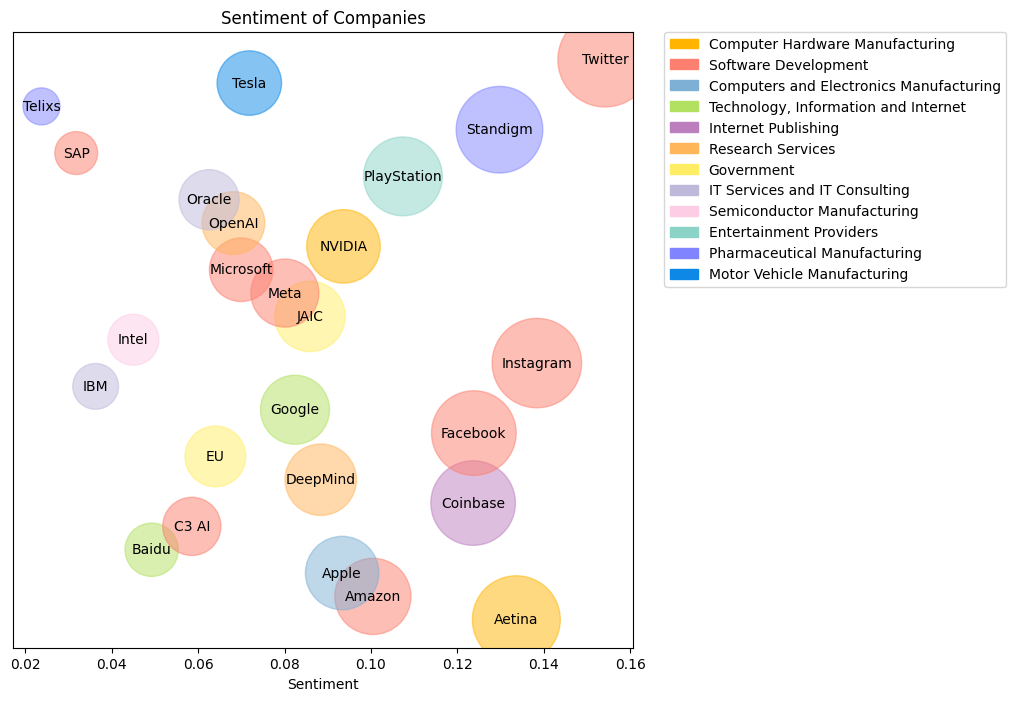

In [159]:
# Make a bubble chart to show the sentiment of each company
plt.figure(figsize=(8,8))
plt.scatter(ORG_avg_sentiment['Sentiment'], ORG_avg_sentiment['Entities'], s=ORG_avg_sentiment['Sentiment']*30000, alpha=0.5, c=ORG_avg_sentiment['Industry'].map(industry_color))
plt.xlabel('Sentiment')
plt.title('Sentiment of Companies')

# add legend to the bubble chart
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color, label=label) for label, color in industry_color.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# annotate the company name
for i, txt in enumerate(ORG_avg_sentiment['Entities']):
    plt.annotate(txt, (ORG_avg_sentiment['Sentiment'][i], ORG_avg_sentiment['Entities'][i]), fontsize=10,
                 horizontalalignment='center', verticalalignment='center', color='black')

# drop y axis label
plt.yticks([])


plt.show()

## AI Solutions Targeted Sentiment Analysis

In [160]:
# filter rows where entities are in AI_entities
AI_sentiment_df = ner_sentiment_df[ner_sentiment_df['Entities'].isin(AI_entities['Entities'])]
AI_sentiment_df

,id,Entities,Labels,Sentiment,Subjectivity
424,8,AIgenerated,ORG,0.000000,0.325000
502,9,AIgenerated,ORG,0.000000,0.000000
514,9,AIgenerated,ORG,-0.150000,0.200000
992,15,DGX,ORG,0.600000,1.000000
993,15,A100,PRODUCT,0.600000,1.000000
...,...,...,...,...,...
12011965,200324,ChatGPT,ORG,0.387374,0.807912
12011978,200324,GPT,ORG,0.500000,0.500000
12011988,200324,ChatGPT,ORG,0.175000,0.325000
12011994,200324,ChatGPT,ORG,0.020000,0.180000


In [161]:
AI_sentiment_df['Entities'].value_counts()

Entities
ChatGPT              137335
ML                    25222
Machine Learning      17145
Bard                  16036
Bing                  15329
GPT3                   8427
GPT                    7749
AIgenerated            7151
Lunit                  5485
Google Cloud           4264
Conversational AI      3611
HPC                    3563
A.I.                   2978
DGX                    1994
Vectorspace AI         1787
Ernie Bot              1705
Cresta                 1662
Akismet                1412
TensorFlow             1398
ADAS                   1364
A100                   1301
Weve                   1185
Laivly                 1172
Cloud                  1087
JavaScript             1072
Hailo                  1048
SageMaker               853
Jina AI                 796
SoundHound AI           554
Name: count, dtype: int64

In [162]:
# Rename 'Machine Learning' to 'ML' in AI_sentiment_df
AI_sentiment_df['Entities'] = AI_sentiment_df['Entities'].replace('Machine Learning', 'ML')
AI_sentiment_df

,id,Entities,Labels,Sentiment,Subjectivity
424,8,AIgenerated,ORG,0.000000,0.325000
502,9,AIgenerated,ORG,0.000000,0.000000
514,9,AIgenerated,ORG,-0.150000,0.200000
992,15,DGX,ORG,0.600000,1.000000
993,15,A100,PRODUCT,0.600000,1.000000
...,...,...,...,...,...
12011965,200324,ChatGPT,ORG,0.387374,0.807912
12011978,200324,GPT,ORG,0.500000,0.500000
12011988,200324,ChatGPT,ORG,0.175000,0.325000
12011994,200324,ChatGPT,ORG,0.020000,0.180000


In [163]:
# group by id and entities to ignore the influence of multiple entities in one article
AI_sentiment_df = AI_sentiment_df.groupby(['id', 'Entities']).agg({'Sentiment': 'mean', 'Subjectivity': 'mean'}).reset_index()
AI_sentiment_df

,id,Entities,Sentiment,Subjectivity
0,8,AIgenerated,0.000000,0.325000
1,9,AIgenerated,-0.075000,0.100000
2,15,A100,0.600000,1.000000
3,15,DGX,0.600000,1.000000
4,20,ChatGPT,0.375000,1.000000
...,...,...,...,...
76100,200323,Bing,0.128788,0.484848
76101,200323,ChatGPT,0.085758,0.261970
76102,200324,ChatGPT,0.194125,0.437637
76103,200324,GPT,0.500000,0.500000


In [164]:
# group by entities and take the average of sentiment and subjectivity
AI_avg_sentiment = AI_sentiment_df.groupby(['Entities'])[['Sentiment', 'Subjectivity']].mean().reset_index()
AI_avg_sentiment

,Entities,Sentiment,Subjectivity
0,A.I.,0.073843,0.360507
1,A100,0.130133,0.416913
2,ADAS,0.153215,0.483112
3,AIgenerated,0.103370,0.439061
4,Akismet,0.022097,0.105378
5,Bard,0.099847,0.397496
6,Bing,0.076106,0.409534
7,ChatGPT,0.087202,0.439224
8,Cloud,0.099501,0.362180
9,Conversational AI,0.148894,0.418981


In [165]:
# sort by sentiment
AI_avg_sentiment.sort_values(by=['Sentiment'], ascending=False)

,Entities,Sentiment,Subjectivity
27,Weve,0.182913,0.476366
10,Cresta,0.171702,0.470023
16,HPC,0.168342,0.455753
2,ADAS,0.153215,0.483112
9,Conversational AI,0.148894,0.418981
19,Jina AI,0.148364,0.421593
25,TensorFlow,0.147654,0.423840
21,Lunit,0.143162,0.357351
11,DGX,0.140227,0.395990
1,A100,0.130133,0.416913


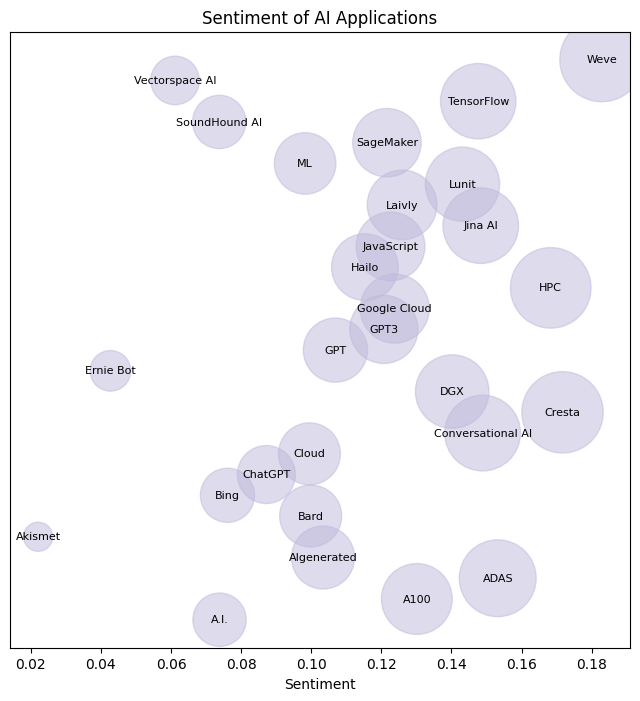

In [166]:
# Make a bubble chart to show the sentiment of each company
plt.figure(figsize=(8,8))
plt.scatter(AI_avg_sentiment['Sentiment'], AI_avg_sentiment['Entities'], s=AI_avg_sentiment['Sentiment']*20000, alpha=0.5, c="#beb9db")
plt.xlabel('Sentiment')
plt.title('Sentiment of AI Applications')

# annotate the company name
for i, txt in enumerate(AI_avg_sentiment['Entities']):
    plt.annotate(txt, (AI_avg_sentiment['Sentiment'][i], AI_avg_sentiment['Entities'][i]), fontsize=8,
                 horizontalalignment='center', verticalalignment='center', color='black')
    
# drop y axis label
plt.yticks([])

plt.show()